# Set-up

## Imports

In [1]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 200
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm, trange
import plotly.graph_objects as go

# Sci-kit learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, f1_score, classification_report, matthews_corrcoef, PrecisionRecallDisplay
import joblib
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# ALE
from alibi.explainers import ALE, plot_ale

## Parameters

In [63]:
scope = 'BID'
input_path = f'../data/3_output/ML_dataset_{scope}.pkl'

train_years = [2021]
test_years = [2022]

subsample_frac = 0.1

target = 'Result'

features_to_encode = [
    'MargTech',
    'WorkDay',
    'Prov',
    'Tech',
]

other_features = [
    'hour',
    'SC_PC1',
    'SC_PC2',
    'IN_PC1',
    'IN_PC2',
    'CT_PC1',
    'CT_PC2',
    'PurchMGP',
    'SellMGP',
    'SolarAngle',
    'DeclAngle',
    'PVnew',
    'PriceDiff',
]

features = other_features + features_to_encode

# Main

## Load data

In [64]:
input_df = pd.read_pickle(input_path)
print("{:,}".format(len(input_df)))
input_df.head(3)

2,177,292


,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,SolarAngle,DeclAngle,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result
2018010118UP_ALTOADDA_1_BID,18,20180101,2018,UP_ALTOADDA_1,BID,2.083112,0.480035,-1.932233,-0.782315,1.912031,...,76.773894,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.349,False
2018010119UP_ALTOADDA_1_BID,19,20180101,2018,UP_ALTOADDA_1,BID,1.249924,0.598779,-1.772487,-0.866850,0.891173,...,91.773894,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.329,False
2018010120UP_ALTOADDA_1_BID,20,20180101,2018,UP_ALTOADDA_1,BID,0.243493,0.768175,-1.758348,-0.872364,-0.334594,...,106.773894,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.324,False


In [65]:
# Subsample
if subsample_frac is not None:
    print(f'Subsampled {100*subsample_frac:.0f}% rows from the input dataset')
    df = input_df.sample(frac=subsample_frac)
else:
    df = input_df.copy()

print('Input dataset is composed of {:,} observations'.format(len(input_df)))
print('{:.1%} bids accepted in the input dataset\n'.format(input_df[target].sum() / len(input_df)))

train_df = df[df.year.isin(train_years)]
print('Training data is composed of {:,} observations and correspond to years {}'.format(len(train_df), ' '.join([str(year) for year in train_years])))
print('{:.1%} bids accepted in the training data\n'.format(train_df[target].sum() / len(train_df)))

test_df = df[df.year.isin(test_years)]
# test_df.dropna(subset=['PriceDiff'], inplace=True) # HOTFIX
# test_df = test_df[~(test_df == np.inf).any(axis=1)] # HOTFIX
print('Test data is composed of {:,} observations and correspond to years {}'.format(len(test_df), ' '.join([str(year) for year in test_years])))
print('{:.1%} bids accepted in the test data'.format(test_df[target].sum() / len(test_df)))

Subsampled 10% rows from the input dataset
Input dataset is composed of 2,177,292 observations
15.9% bids accepted in the input dataset

Training data is composed of 39,461 observations and correspond to years 2021
19.4% bids accepted in the training data

Test data is composed of 33,124 observations and correspond to years 2022
18.3% bids accepted in the test data


In [66]:
# We take of the fact that some categories could be absent in the training set but present in the test set
categories = [input_df[feature].unique() for feature in features_to_encode]

feature_transformer = make_column_transformer(
    (OneHotEncoder(categories=categories), features_to_encode),
    remainder="passthrough",
    verbose_feature_names_out=False
)

X_train = feature_transformer.fit_transform(train_df[features])
y_train = train_df[target]

X_test = feature_transformer.transform(test_df[features])
y_test = test_df[target]

print('Input features are:')
print(feature_transformer.feature_names_in_)

Input features are:
['hour' 'SC_PC1' 'SC_PC2' 'IN_PC1' 'IN_PC2' 'CT_PC1' 'CT_PC2' 'PurchMGP'
 'SellMGP' 'SolarAngle' 'DeclAngle' 'PVnew' 'PriceDiff' 'MargTech'
 'WorkDay' 'Prov' 'Tech']


## Load model

In [67]:
model_path = '{}/model_dumps/model_trained_{}_{}.joblib'.format(scope, scope, '_'.join([str(year) for year in train_years]))
clf = joblib.load(model_path)
print(f'Model {model_path} loaded\n')

Model BID/model_dumps/model_trained_BID_2021.joblib loaded



## Permutation Feature Importance

In [68]:
clf_pipeline = make_pipeline(feature_transformer, clf)

In [42]:
train_result = permutation_importance(
    clf_pipeline, train_df[features], y_train, scoring='average_precision', random_state=42, n_jobs=-1
)

In [43]:

test_result = permutation_importance(
    clf_pipeline, test_df[features], y_test, scoring='average_precision', random_state=42, n_jobs=-1
)

In [44]:
sorted_importances_idx = test_result.importances_mean.argsort()

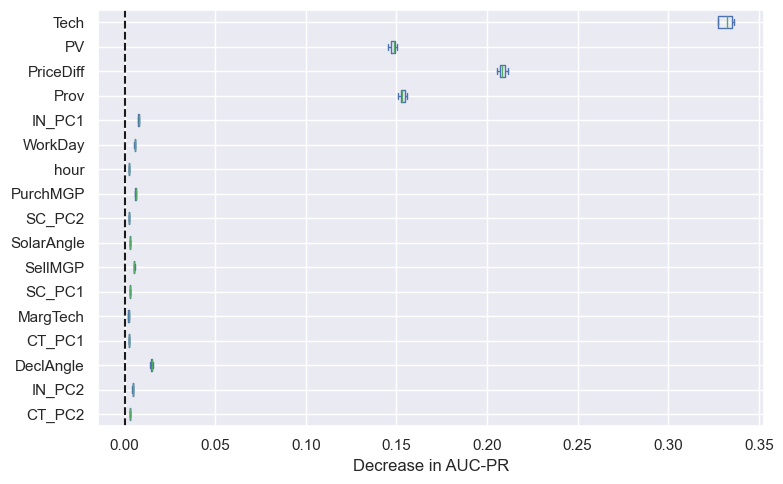

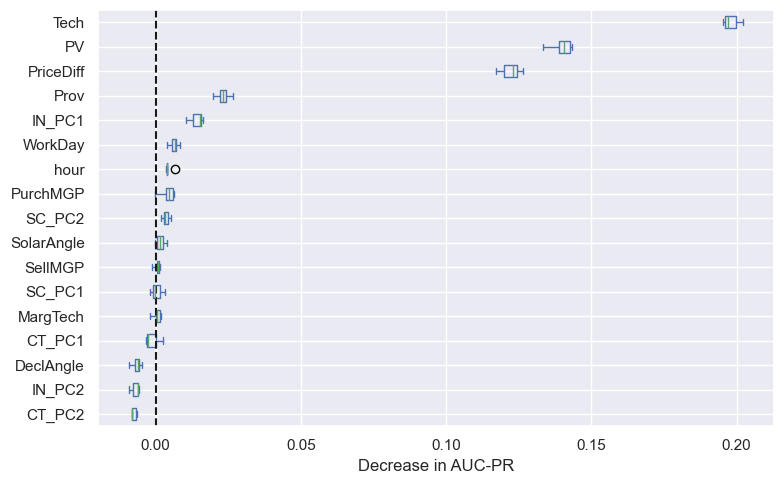

In [45]:
columns = train_df[features].columns[sorted_importances_idx]
columns = ['PV' if col == 'PVnew' else col for col in columns]

train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=columns,
)
test_importances = pd.DataFrame(
    test_result.importances[sorted_importances_idx].T,
    columns=columns,
)

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
# for name, importances in zip(["train"], [train_importances]):
    ax = importances.plot.box(vert=False, whis=10, figsize=(8,5))
    # ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in AUC-PR")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

In [46]:
test_importances

,CT_PC2,IN_PC2,DeclAngle,CT_PC1,MargTech,SC_PC1,SellMGP,SolarAngle,SC_PC2,PurchMGP,hour,WorkDay,IN_PC1,Prov,PriceDiff,PV,Tech
0,-0.007993,-0.007597,-0.006031,-0.002823,0.001792,-0.000815,0.000391,0.001607,0.004319,0.006227,0.003837,0.003828,0.015712,0.024370,0.119809,0.140591,0.195200
1,-0.006305,-0.005834,-0.005552,0.000283,0.001374,-0.001795,0.000774,0.003965,0.001858,0.006111,0.006566,0.007163,0.015368,0.022056,0.123008,0.133494,0.195966
2,-0.008078,-0.006093,-0.007070,-0.003163,0.000444,-0.000343,0.001438,-0.000302,0.002836,0.003678,0.003572,0.005665,0.012927,0.019946,0.126387,0.142636,0.199837
3,-0.006633,-0.006064,-0.009088,0.002700,0.000102,0.001521,0.001144,0.000641,0.005418,0.004695,0.003892,0.006631,0.016473,0.023380,0.117322,0.138871,0.196929
4,-0.008084,-0.009206,-0.004644,-0.002721,-0.001919,0.003422,-0.001137,0.002643,0.003360,-0.000197,0.003895,0.008253,0.010477,0.026675,0.124561,0.143498,0.202273


## Partial Dependence Plot

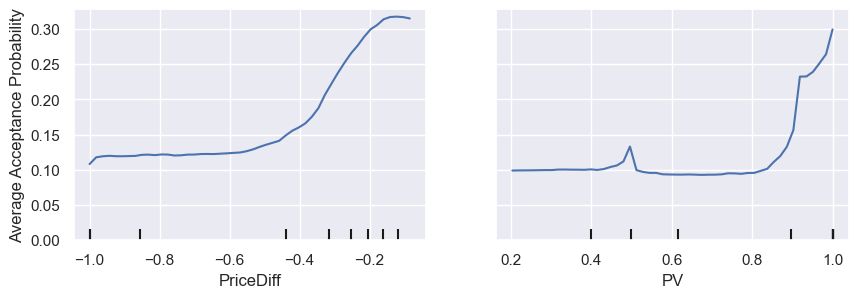

In [69]:
disp = PartialDependenceDisplay.from_estimator(
    clf_pipeline,
    X = test_df[features],
    features = ['PriceDiff', 'PVnew'],
    # categorical_features = np.array([col in features_to_encode for col in test_df[features].columns.to_list()]),
    n_jobs = -1,
    kind = ['average', 'average'],
    subsample = 100,
    grid_resolution = 50,  # Optional: controls the resolution of the grid for plotting
    n_cols = 2,  # This arranges the subplots in two columns
)

# xtick_names = ['FG', 'FHC', 'HPS', 'HRP', 'HWR', 'TE']
# disp.figure_.axes[1].set_xticklabels(xtick_names)

# Change the x-axis labels for each subplot
x_labels = ['PriceDiff', 'PV']
# # Change the y-axis labels for each subplot
# y_labels = ['Average Acceptance Probability', 'Average Acceptance Probability']

# Iterate over each subplot and set the x-axis label
for ax, label in zip(disp.axes_.ravel(), x_labels):
    ax.set_xlabel(label)

disp.axes_[0,0].set_ylabel('Average Acceptance Probability')
disp.axes_[0,0].set_ylim(bottom=0)
disp.axes_[0,1].set_ylim(bottom=0)

# # Set the y-axis limits and labels
# for ax, x_label, y_label in zip(disp.axes_.ravel(), x_labels, y_labels):
#     ax.set_xlabel(x_label)
#     ax.set_ylabel(y_label)
#     ax.set_ylim(bottom=0)  # Set the y-axis to start at 0

# # Force the subplots to share the same y-axis
# for ax in disp.axes_.ravel()[1:]:  # Skip the first subplot as it will be the reference
#     ax.get_shared_y_axes().join(disp.axes_.ravel()[0], ax)

disp.figure_.set_size_inches(10,3)
disp.figure_.subplots_adjust(hspace=0.1)

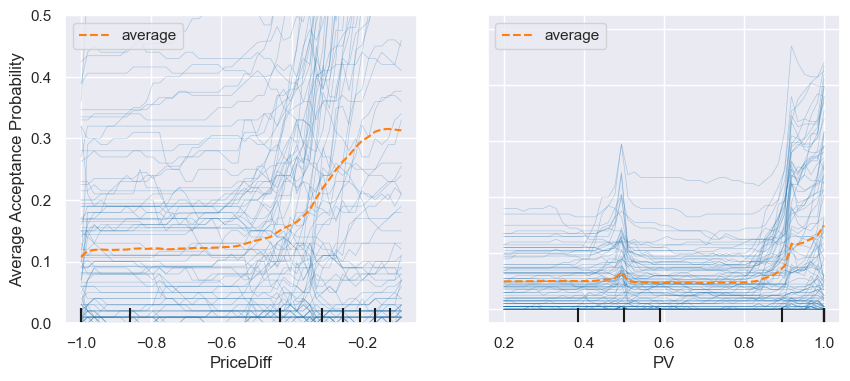

In [49]:
disp = PartialDependenceDisplay.from_estimator(
    clf_pipeline,
    X = test_df[features],
    features = ['PriceDiff', 'PVnew'],
    # categorical_features = np.array([col in features_to_encode for col in test_df[features].columns.to_list()]),
    n_jobs = -1,
    kind = ['both', 'both'],
    subsample = 100,
    grid_resolution = 50,  # Optional: controls the resolution of the grid for plotting
    n_cols = 2  # This arranges the subplots in two columns
)

# xtick_names = ['FG', 'FHC', 'HPS', 'HRP', 'HWR', 'TE']
# disp.figure_.axes[1].set_xticklabels(xtick_names)

# Change the x-axis labels for each subplot
x_labels = ['PriceDiff', 'PV']

# Iterate over each subplot and set the x-axis label
for ax, label in zip(disp.axes_.ravel(), x_labels):
    ax.set_xlabel(label)

disp.axes_[0,0].set_ylabel('Average Acceptance Probability')
disp.axes_[0,0].set_ylim(bottom=0, top=0.5)

disp.figure_.set_size_inches(10,4)
disp.figure_.subplots_adjust(hspace=0.3)

## Accumulated Local Effects (ALE)

In [32]:
predictor = clf.predict_proba

# Features to explain should be numerical or ordinal
encoded_feature_names = list(feature_transformer.get_feature_names_out())
features_to_explain = [encoded_feature_names.index(feature) for feature in ['PVnew', 'PriceDiff', 'IN_PC1']]

ale = ALE(predictor, encoded_feature_names, target_names=['Rejected', 'Accepted'])
ale = ale.explain(X_test.toarray(), features=features_to_explain)

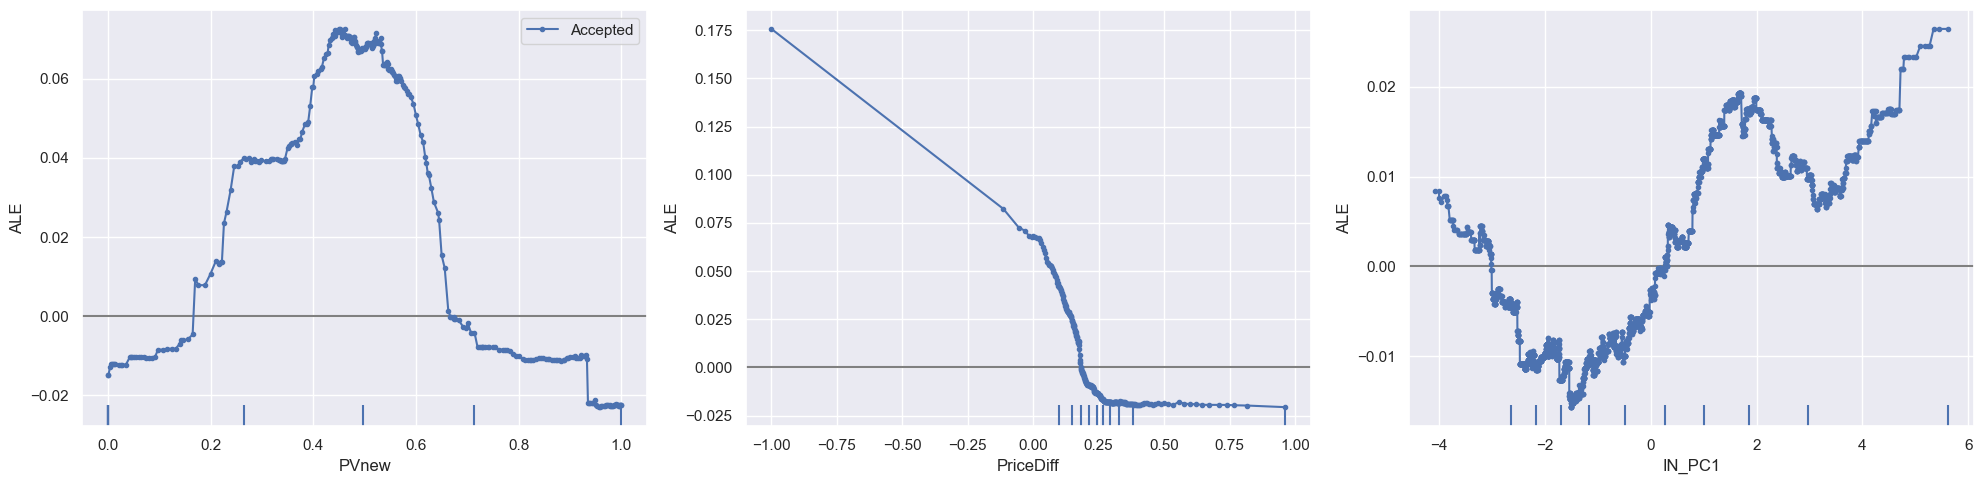

In [33]:
plot_ale(ale, targets=['Accepted'], n_cols=4, fig_kw={'figwidth': 20, 'figheight': 5}, sharey=None)
plt.tight_layout()